# Обучение без учителя в Scikit-learn

Ранее мы познакомились с понятием обучения с учителем. В тех задачах у нас имелись какие-то данные, а также набор правильных ответов на этих данных. Тогда нашей задачей было научиться предсказывать аналогичный ответ на данных, которые мы раньше не видели.

В отличие от обучения с учителем, в задачах обучения без учителя эти правильные ответы отсутствуют. В таком случае нам уже не нужно предсказывать какую-то величину, а лишь понять, как связаны между собой объекты из нашей выборки.

## Кластеризация

Одним из самых часто применяемых методов обучения без учителя является _кластеризация_. Задача кластеризации -  разбить объекты из выборки на определённое число групп (или _кластеров_) так, чтобы "похожие" объекты попали в один кластер. 

Здесь мы познакомимся с одним из наиболее известных алгоритмов кластеризации - _k-means_ или _k средних_.

In [26]:
from sklearn.cluster import KMeans

model = KMeans(n_clusters=3, random_state=100)

Данная модель принимает на вход параметр `n_clusters`, т.е. число кластеров, на которые мы хотели бы разбить наши данные.

На начальной итерации алгоритм произвольным образом выбирает центры кластеров - _центроиды_ (столько, сколько мы задали в параметре `n_clusters`). Затем повторяется следующий процесс:

1. Отнести каждый объект из выборки к тому кластеру, чей центр ближе всего к этому объекту.
2. Переставить центроид каждого кластера в центр этого кластера (с учётом новых объектов).

Этот процесс повторяется до тех пор, пока координаты центров не перестанут изменяться.

Разберёмся с этим алгоритмом на практике. Для этого воспользуемся готовой функцией для создания датасета.

In [27]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

plt.style.use('fivethirtyeight')

%config InlineBackend.figure_format = 'svg'
%matplotlib inline

In [28]:
def make_data(n, seed):
    np.random.seed(seed)
    
    shift_matrix = np.array([[3, 3], 
                             [6, 9], 
                             [9, 3]])
    
    data = np.random.randn(3, 2, n) + shift_matrix.reshape((3, 2, 1))
    data = np.swapaxes(data, 1, 2)
    data = data.reshape((-1, 2))
    data *= np.array([[20, 0.5]])
    
    df = pd.DataFrame({'x': data[:, 0], 'y': data[:, 1]},
                      columns=['x', 'y'])
    df = df.sample(frac=1.0)

    return df

Эта функция принимает на вход параметры `n` (число объектов в каждой группе объектов) и `seed` (зерно, необходимое для воспроизводимости случайных значений). В результате получается `DataFrame`, содержащий заданное число объектов в каждой группе (всего 3 группы) с двумя признаками: `'x'` и `'y'`.

Получим с помощью этой функции два набора данных. 

In [29]:
train = make_data(10, 42)
test = make_data(10, 27)

Чтобы придать данным больший предметный смысл, представим, что полученные нами данные - это данные о разных видах рыб, обитающих в водоёме. Мы бы хотели разбить представителей рыб из этого водоёма на 3 кластера.

Посмотрим, как расположены наши объекты в пространстве. Поскольку у каждого объекта всего два признака, мы можем представить каждый объект как точку на плоскости:

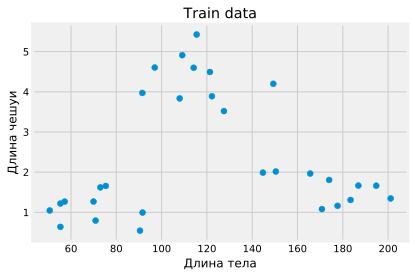

In [30]:
plt.scatter(train['x'], train['y'])

plt.xlabel('Длина тела')
plt.ylabel('Длина чешуи')

plt.title('Train data')

plt.show()

Прежде чем приступить к кластеризации, отмасштабируем наши данные с помощью уже знакомого нам `MinMaxScaler`:

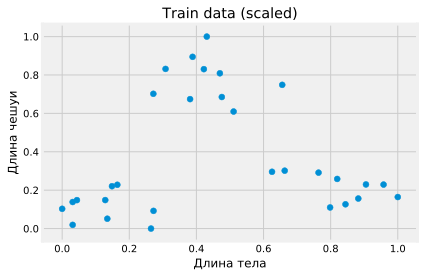

In [31]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

train_scaled = pd.DataFrame(scaler.fit_transform(train), columns=['x', 'y'])

plt.scatter(train_scaled['x'], train_scaled['y'])

plt.xlabel('Длина тела')
plt.ylabel('Длина чешуи')

plt.title('Train data (scaled)')

plt.show()

Итак, перейдём к кластеризации. С помощью метода `.fit_predict` можно обучить модель, а затем сразу же получить метки кластеров на входных данных:

In [32]:
train_labels = model.fit_predict(train_scaled)

print(train_labels)

[0 0 1 1 1 0 2 0 2 1 1 2 2 2 2 2 0 2 0 0 1 2 1 1 0 0 0 2 1 1]


С помощью атрибута `.cluster_centers_` можно получить получившиеся в результате работы алгоритма центры кластеров. Чтобы изобразить эти центры на плоскости, воспользуемся методом `scaler.inverse_transform`, который преобразует отмасштабированные значения обратно в сырые. Центры на графике пометим красными ромбами. Кроме того, покрасим объекты из разных кластеров в разные цвета для наглядности.

Text(0.5, 1.0, 'Train data')

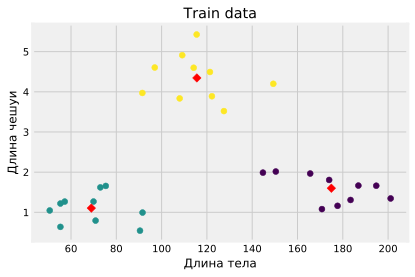

In [33]:
centers = scaler.inverse_transform(model.cluster_centers_)

plt.scatter(train['x'], train['y'], c=train_labels)
plt.scatter(centers[:, 0], centers[:, 1], marker='D', color='red')

plt.xlabel('Длина тела')
plt.ylabel('Длина чешуи')

plt.title('Train data')

Основная проблема алгоритма k-means в том, что нам нужно заранее знать количество кластеров. Однако, в реальности это не всегда бывает возможно. Количество кластеров можно оценить, используя величину _inertia_. Эта величина равна сумме квадратов расстояний от объектов до центров их кластеров. Чем лучше кластеризация, тем меньше эта величина. Кроме того, она уменьшается с увеличением числа кластеров (она равна 0, если кластеров столько же, сколько объектов), поэтому нужно соблюдать баланс между количеством кластеров, которое нам подходит, и величиной inertia, чтобы число кластеров было разумным.

In [34]:
model.inertia_

0.5417377477488047

Посчитаем эту величину на наших данных при различном количестве кластеров.

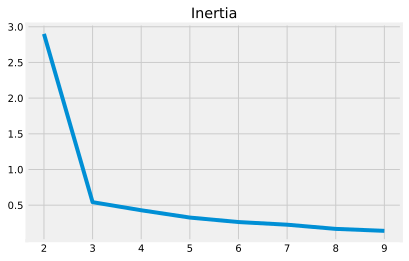

In [35]:
inertias = []

for i in range(2, 10):
    temp_model = KMeans(n_clusters=i, random_state=100)
    temp_model.fit(train_scaled)
    
    temp_inertia = temp_model.inertia_
    
    inertias.append(temp_inertia)

plt.plot(range(2, 10), inertias)

plt.title('Inertia')

plt.show()

Мы видим сильное снижение inertia при переходе от 2 к 3 кластерам, а дальше идёт более плавное уменьшение. Это означает, что 3 - адекватное число кластеров. Такой подход называется _методом локтя_.

Теперь перейдём к тестовым данным. Нормализуем их, а затем попробуем отнести их к одному из получившихся кластеров.

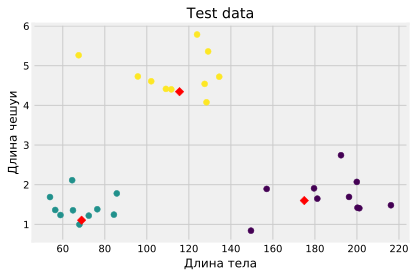

In [36]:
test_scaled = pd.DataFrame(scaler.transform(test), columns=['x', 'y'])

test_labels = model.predict(test_scaled)

plt.scatter(test['x'], test['y'], c=test_labels)
plt.scatter(centers[:, 0], centers[:, 1], marker='D', color='red')

plt.xlabel('Длина тела')
plt.ylabel('Длина чешуи')

plt.title('Test data')

plt.show()

Как мы видим, каждый объект из тестовых данных вполне оправданно был отнесён к соответствующему кластеру.

### Агломеративная кластеризация

Перейдём к _иерархической кластеризации_, которая в свою очередь состоит из _агломеративной_ и _дивизивной_ кластеризации.

Алгоритмы _агломеративной_ кластеризации основаны на объединении мелких кластеров в более крупные. На начальной итерации каждый объект считается отдельным кластером, затем происходит их последовательное объединение. Напротив, _дивизивная_ кластеризация - это обратный процесс: сначала вся выборка считается одним большим кластером, затем происходит последовательное разбиение кластеров на части.

Text(0.5, 1.0, 'Train data')

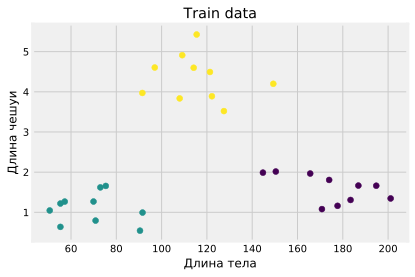

In [37]:
from sklearn.cluster import AgglomerativeClustering

model = AgglomerativeClustering(n_clusters=3)

train_labels = model.fit_predict(train_scaled)

plt.scatter(train['x'], train['y'], c=train_labels)

plt.xlabel('Длина тела')
plt.ylabel('Длина чешуи')

plt.title('Train data')

Отметим, что у модели `AgglomerativeClustering` нет метода `.predict`. Поэтому чтобы предсказать разбиение на кластеры для тестовых данных, воспользуемся уже известным нам алгоритмом KNN. Будем использовать полученные только что метки классов `train_labels` для того, чтобы превратить нашу задачу в задачу обучения с учителем.

Text(0.5, 1.0, 'Test data')

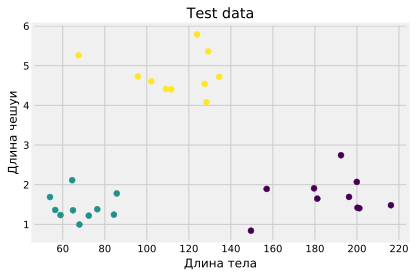

In [38]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(train_scaled, train_labels)

test_labels = knn.predict(test_scaled)

plt.scatter(test['x'], test['y'], c=test_labels)

plt.xlabel('Длина тела')
plt.ylabel('Длина чешуи')

plt.title('Test data')

## Понижение размерности данных

Предположим, перед нами стоит задача обучения с учителем, и в наших данных очень много признаков (сотни, тысячи или даже больше). На таком количестве признаков модель построить практически невозможно: нам просто не хватит вычислительной мощности.

В таких случаях можно пользоваться методами понижения размерности. Такие методы позволяют "сжать" данные, уменьшая число признаков в них, при этом сделать это так, чтобы потеря информации была минимальной.

Один из таких методов - _Метод главных компонент_ (_Principal component analysis_ или _PCA_). Для нахождения главных компонент нужно вычислить ковариационную матрицу, затем для этой матрицы найти собственные векторы и собственные значения. (Также есть способ нахождения главных компонент с помощью сингулярного разложения.)

Перед применением данного метода важно не забыть привести все данные к схожему масштабу. Это можно сделать, например, с помощью стандартизации или нормализации.

Создадим небольшой набор данных чтобы на нём познакомиться с методом главных компонент. Это будет набор данных с двумя признаками:

1. количество комнат в доме
2. площадь дома

In [39]:
houses = np.array([[5, 1.6],
                   [4, 1.4],
                   [6, 1.9],
                   [3, 1.1],
                   [4, 1.25]])

Изобразим эти данные на плоскости:

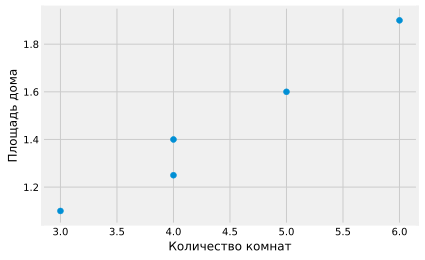

In [40]:
plt.scatter(houses[:, 0], houses[:, 1])

plt.xlabel('Количество комнат')
plt.ylabel('Площадь дома')

plt.show()

Из графика видно, что два признака сильно коррелируют: их можно расположить практически на одной прямой. Это означает, что наши данные можно сжать с двух до одного измерения (представить данные одной _главной компонентой_) с минимальной потерей информации.

Разберём подробнее алгоритм метода главных компонент. Вначале нужно центрировать наши данные, т.е. преобразовать их так, чтобы среднее значение каждого признака было равно 0. Для этого вычтем из матрицы признаков средние значения по каждому признаку:

In [41]:
houses_centered = houses - houses.mean(axis=0)

print(houses_centered)

[[ 0.6   0.15]
 [-0.4  -0.05]
 [ 1.6   0.45]
 [-1.4  -0.35]
 [-0.4  -0.2 ]]


Теперь посчитаем _матрицу ковариаций_. Это матрица, состоящая из попарных ковариаций признаков. Это своего рода многомерный аналог дисперсии. Матрицу ковариаций можно посчитать с помощью функции `np.cov`:

In [42]:
covariance_matrix = np.cov(houses_centered.T)

Отметим, что данная функция (как и многие функции из линейной алгебры) принимает на вход матрицу, у которой векторы расположены в столбцах (а не в строках, как мы привыкли). Поэтому внутрь этой функции мы подаём транспонированную матрицу `houses_centered.T`.

In [43]:
print(covariance_matrix)

[[1.3    0.35  ]
 [0.35   0.0975]]


У нас получилась матрица размера $2 \times 2$, поскольку число признаков равно 2. На главной диагонали этой матрицы стоят дисперсии соответствующих признаков. Например, посчитаем дисперсию первого признака вручную:

In [44]:
np.var(houses_centered[:, 0], ddof=1)

1.3

Здесь мы подали параметр `ddof=1`, чтобы посчитать несмещённую дисперсию.

Теперь найдём _собственные значения_ (_eigenvalues_) и _собственные векторы_ (_eigenvectors_) данной матрицы. Это можно сделать с помощью функции `np.linalg.eig`:

In [45]:
eigenvalues, eigenvectors = np.linalg.eig(covariance_matrix)

print('eigenvalues:\n{}\n'.format(eigenvalues))
print('eigenvectors:\n{}'.format(eigenvectors))

eigenvalues:
[1.39445221 0.00304779]

eigenvectors:
[[ 0.96546225 -0.26054298]
 [ 0.26054298  0.96546225]]


Метод главных компонент заключается в том, что если мы хотим сжать число признаков с $n$ признаков до $k$ признаков, то нам выгоднее всего взять $k$ наибольших собственных значений матрицы ковариаций. Этим $k$ наибольшим значениям соответствуют $k$ собственных векторов (обратите внимание, что векторы здесь также записаны в столбцах). Чтобы получить "сжатые" данные, остаётся лишь умножить нашу матрицу объект-признак на эти $k$ векторов-столбцов.

В нашем случае мы хотим получить данные с 1 признаком, поэтому возьмём только первое собственное значение (оно сильно больше, чем второе). Ему соответствует вектор `eigenvectors[:, 0]`. Умножим нашу матрицу с центрированными данными на этот вектор.

In [46]:
result = houses_centered.dot(eigenvectors[:, 0])

print(result)

[ 0.6183588  -0.39921205  1.66198394 -1.44283719 -0.4382935 ]


Наконец, расположим эти значения в столбце, чтобы получить матрицу объект-признак:

In [47]:
result = result.reshape(-1, 1)

print(result)

[[ 0.6183588 ]
 [-0.39921205]
 [ 1.66198394]
 [-1.44283719]
 [-0.4382935 ]]


Всю проделанную нами работу можно выполнить и автоматически с помощью библиотеки `sklearn`:

In [48]:
from sklearn.decomposition import PCA

pca = PCA(n_components=1)

result_ = pca.fit_transform(houses)

print(result_)

[[ 0.6183588 ]
 [-0.39921205]
 [ 1.66198394]
 [-1.44283719]
 [-0.4382935 ]]


Кроме того, использование модели из `sklearn` позволяет нам также посмотреть, какую долю объяснённой дисперсии содержит данная главная компонента:

In [49]:
pca.explained_variance_ratio_

array([0.99781911])

Мы видим, что это значение близко к 1. Это означает, что мы потеряли менее 1 процента информации. В общем случае, потеря информации до 10 процентов считается не очень большой.

### Применение PCA в моделях машинного обучения

Попробуем применить метод главных компонент в модели классификации. Загрузим данные по пассажирам Титаника, сохранённые ранее:

In [50]:
X_train = pd.read_pickle('X_train.pkl')
y_train = pd.read_pickle('y_train.pkl')

X_valid = pd.read_pickle('X_valid.pkl')
y_valid = pd.read_pickle('y_valid.pkl')

FileNotFoundError: [Errno 2] No such file or directory: 'X_train.pkl'

Будем масштабировать данные с помощью стандартизации. Подадим стандартизатору параметр `with_mean=False` чтобы не проводить центрирование.

In [ ]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler(with_mean=False)

X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)
X_valid_scaled = pd.DataFrame(scaler.transform(X_valid), columns=X_valid.columns)

Запустим теперь метод главных компонент. Здесь мы не будем указывать число главных компонент, по умолчанию модель `PCA` посчитает все. Посчитаем главные компоненты и посмотрим на долю объяснённой дисперсии каждой компоненты.

In [ ]:
pca = PCA(random_state=100)

pca.fit(X_train_scaled)

print(pca.explained_variance_ratio_)

Посчитаем сумму первых 7 значений:

In [ ]:
pca.explained_variance_ratio_[:7].sum()

Выходит, если мы оставим 7 главных компонент с самой большой объяснённой дисперсией, то мы сохраним почти 92 процента информации.

Ещё раз создадим модель `PCA`, на этот раз указав число компонент, и получим тренировочные и валидационные данные пониженной размерности:

In [ ]:
pca = PCA(n_components=7, random_state=100)

X_train_mc = pca.fit_transform(X_train_scaled)
X_valid_mc = pca.transform(X_valid_scaled)

Теперь обучим на этих данных модель логистической регрессии.

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

lr = LogisticRegression()

lr.fit(X_train_mc, y_train)

y_pred = lr.predict(X_valid_mc)

print(accuracy_score(y_valid, y_pred))

Мы получили вполне приемлемую точность модели несмотря на то, что сильно снизили размерность данных.

## Алгоритм t-SNE

Алгоритм _t-SNE_ (_t-distributed Stochastic Neighbor Embedding_ или _Стохастическое вложение соседей с t-распределением_) позволяет понижать размерность данных до двух или трёх измерений, что позволяет визуализировать данные на двумерных и трёхмерных графиках. Изучая графики, можно, например, понять, на сколько кластеров адекватно разбивать данные, а также оценить уже выполненное разбиение на кластеры.

Разберёмся в работе этого алгоритма с помощью датасета Boston из библиотеки `sklearn`.

In [ ]:
from sklearn.manifold import TSNE
from sklearn.datasets import load_boston

boston = load_boston()

X = pd.DataFrame(boston.data, columns=boston.feature_names)
y = boston.target

X.info()

Видно, что данные представляют из себя 13 столбцов с дробными значениями, пропусков нет.

Разобьём данные на тренировочный и тестовый датасеты.

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=7)

Нам важно чтобы все признаки имели схожиый масштаб, поэтому отмасштабируем их с помощью стандартизации.

In [ ]:
scaler = StandardScaler()

X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)
X_test_scaled = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns)

Итак, перейдём к использованию t-SNE. Зададим параметр `n_components=2`, чтобы получить данные с двумя признаками. Параметр `learning_rate` влияет на то, как плотно будут располагаться точки. Рекомендуется задавать его в диапазоне от 10 до 1000.

In [ ]:
tsne = TSNE(n_components=2, learning_rate=150, random_state=100)

X_train_tsne = tsne.fit_transform(X_train_scaled)

print('До:\t{}'.format(X_train_scaled.shape))
print('После:\t{}'.format(X_train_tsne.shape))

Мы видим, что число признаков уменьшилось с 13 до 2. Теперь можно визуализировать наши данные на плоскости.

In [ ]:
plt.scatter(X_train_tsne[:, 0], X_train_tsne[:, 1])

plt.show()

По графику видно, что данные можно разбить как минимум на 2 кластера. Попробуем сделать это с помощью уже известного нам метода K-means и ещё раз построим график, но уже с полученными метками кластеров.

In [ ]:
kmeans = KMeans(n_clusters=2)

labels_train = kmeans.fit_predict(X_train_scaled)

plt.scatter(X_train_tsne[:, 0], X_train_tsne[:, 1], c=labels_train)

plt.show()

Как мы видим, при кластеризации мы получили практически такое же разбиение, как то, которое можно было наблюдать в результате t-SNE.

Для тестовой выборки получить аналогичный график нам не удастся, поскольку у алгоритма t-SNE нет метода `.transform`. Однако, с помощью алгоритма K-means мы можем получить метки кластеров для тестовой выборки с помощью метода `.predict` и использовать их:

In [ ]:
labels_test = kmeans.predict(X_test_scaled)

Давайте посмотрим на объекты из разных кластеров, чтобы попытаться понять, почему алгоритм t-SNE выделил две группы. Например, посмотрим на среднюю цену недвижимости во всей выборке и в отдельных кластерах.

In [ ]:
y_train.mean()

In [ ]:
y_train[labels_train == 0].mean()

In [ ]:
y_train[labels_train == 1].mean()

Видно, что в первый кластер попала более дорогая недвижимость, а во второй - менее дорогая. Построим также гистограммы распределения цены по каждому кластеру.

In [ ]:
plt.hist(y_train[labels_train == 0], bins=20, density=True, alpha=0.5)
plt.hist(y_train[labels_train == 1], bins=20, density=True, alpha=0.5)

plt.legend(['Кластер 0', 'Кластер 1'])
plt.xlabel('Цена')

plt.show()

Гистограмма также отражает замеченную закономерность. Заметим, что мы не использовали цену на недвижимость ни при использовании t-SNE, ни при использовании K-means.

Посмотрим теперь на распределение отдельных признаков внутри кластеров. Например, `'RM'` - количество комнат.

In [ ]:
print('Кластер 0: {}'.format(X_train.loc[labels_train == 0, 'RM'].mean()))
print('Кластер 1: {}'.format(X_train.loc[labels_train == 1, 'RM'].mean()))

Значения не сильно отличаются. Не похоже, что этот признак внёс какой-то вклад в разбиение. Рассмотрим другой признак - `'CRIM'`. Он отражает криминальность места, в котором расположена недвижимость (количество преступлений на душу населения).

In [ ]:
print('Кластер 0: {}'.format(X_train.loc[labels_train == 0, 'CRIM'].mean()))
print('Кластер 1: {}'.format(X_train.loc[labels_train == 1, 'CRIM'].mean()))

Видно, что данное значение сильно выше для второго кластера. Рассмотрим гистограммы распределений значений этого признака по кластерам.

In [ ]:
plt.hist(X_train.loc[labels_train == 0, 'CRIM'], bins=20, density=True, alpha=0.5)
plt.hist(X_train.loc[labels_train == 1, 'CRIM'], bins=20, density=True, alpha=0.5)

plt.xlim(0, 12)
plt.legend(['Кластер 0', 'Кластер 1'])
plt.xlabel('CRIM')

plt.show()

В кластере 0 максимальная плотность этого признака расположена возле 0. Для кластера 1 значения этого признака более разнообразны.

Ещё один интересный признак - концентрация оксида азота в воздухе (`'NOX'`). Построим гистограммы распределения этого признака.

In [ ]:
plt.hist(X_train.loc[labels_train == 0, 'NOX'], bins=20, density=True, alpha=0.5)
plt.hist(X_train.loc[labels_train == 1, 'NOX'], bins=20, density=True, alpha=0.5)

plt.xlim(0, 1.2)
plt.legend(['Кластер 0', 'Кластер 1'])
plt.xlabel('NOX')

plt.show()

Вновь кластер 1 в этом плане отличается в худшую сторону. 

Итак, как нам теперь использовать полученную информацию? Мы можем, например, попробовать построить отдельную модель для каждого кластера. Сначала построим модель на всех данных. Для оценки качества модели будем использовать `r2_score`.

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

lr = LinearRegression()

lr.fit(X_train_scaled, y_train)

y_test_pred = lr.predict(X_test_scaled)

r2_score(y_test, y_test_pred)

Итак, мы получили базовое значение. Построим теперь разные модели для объектов разных кластеров и посмотрим, какое качество мы сможем получить на них.

Модель для кластера 0:

In [ ]:
lr.fit(X_train_scaled.loc[labels_train == 0], y_train[labels_train == 0])

y_test_pred_0 = lr.predict(X_test_scaled.loc[labels_test == 0])

r2_score(y_test[labels_test == 0], y_test_pred_0)

Модель для кластера 1:

In [ ]:
lr.fit(X_train_scaled.loc[labels_train == 1], y_train[labels_train == 1])

y_test_pred_1 = lr.predict(X_test_scaled.loc[labels_test == 1])

r2_score(y_test[labels_test == 1], y_test_pred_1)

Для кластера 0 мы получили большее значение `r2_score`, однако, сравнивать эти модели пока рано, потому что данное значение получено не на всех данных. Соберём теперь данные по кусочкам и проверим значение `r2_score`.

In [ ]:
y_test_all = np.hstack([y_test[labels_test == 0], y_test[labels_test == 1]])
y_test_pred_all = np.hstack([y_test_pred_0, y_test_pred_1])

r2_score(y_test_all, y_test_pred_all)

Итак, теперь можно утверждать, что мы получили значительно более высокий показатель `r2_score`, применив информацию, полученную с помощью t-SNE и K-means.